In [12]:
import pandas as pd

# Load the dataset
file_path1 = "Tweets2.csv"
df = pd.read_csv(file_path1, encoding="latin1")

# Display basic information about the dataset
df.info() 
df.head() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [164]:
# Remove missing values by dropping rows where the 'text' column is empty
df.dropna(subset=["text"], inplace=True)

# Converting sentiment labels to numerical values
sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)

# Clean text
import re

def clean_tweet(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@)
    text = re.sub(r"[^a-zA-Z0-9\s']", "", text)  # Remove special characters but keep apostrophes
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df["clean_text"] = df["text"].apply(clean_tweet)

# Display the first few rows after cleaning
df.head()


,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,0,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,0,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons of why couldnt they put them on the relea...


In [165]:
# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define tokenization parameters
vocab_size = 10000  
max_length = 100  
oov_token = "<OOV>"  # Token for out-of-vocabulary words

# Initialize tokenizer and fit on cleaned text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(df["clean_text"])  

# Convert cleaned text into numerical sequences
X_sequences = tokenizer.texts_to_sequences(df["clean_text"])  # Each word is replaced by its index

# Pad sequences to make all tweets the same length
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post") 

# Convert sentiment labels to a NumPy array
y = np.array(df["sentiment"]) 

# Display dataset shape after transformation
X_padded.shape, y.shape


((27480, 100), (27480,))

In [61]:
# Load GloVe Embeddings into Memory
# Defining path to the GloVe file
glove_file = "glove.twitter.27B.200d.txt"

# Load GloVe embeddings into a dictionary
embeddings_index = {}

with open(glove_file, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]  # First value is the word
        vector = np.asarray(values[1:], dtype="float32")  
        embeddings_index[word] = vector

# Print the number of words loaded
print(f"✅ Loaded {len(embeddings_index)} word vectors from GloVe.")


✅ Loaded 1193514 word vectors from GloVe.


In [62]:
# Create an Embedding Matrix for the Vocabulary
# Retrieve the word index from the tokenizer which maps words to indices
word_index = tokenizer.word_index

# Initialize the embedding matrix with zeros,  matching the size of the vocabulary
embedding_dim = 200  
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # This matrix will store word vectors

for word, i in word_index.items():
    if i < vocab_size:  
        embedding_vector = embeddings_index.get(word)  
        if embedding_vector is not None:  
            embedding_matrix[i] = embedding_vector

# Check the shape of the embedding matrix
embedding_matrix.shape


(10000, 200)

In [63]:
# Import necessary libraries for LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input

# Define LSTM Model with GloVe Embeddings
lstm_model_glove = Sequential([
    Input(shape=(max_length,)),  
    
    # Embedding layer using pre-trained GloVe embeddings
    Embedding(input_dim=vocab_size,  
              output_dim=embedding_dim,  
              weights=[embedding_matrix],  
              input_length=max_length, 
              trainable=False),  
   
    # Bidirectional LSTM layer for better context understanding
    Bidirectional(LSTM(256, return_sequences=True)),  
    Dropout(0.1),  
    LSTM(128),  
    Dropout(0.1), # Another dropout layer to reduce overfitting
    
    # Output layer with 3 classes (positive, neutral, negative sentiments)
    Dense(3, activation="softmax")  
])

#Compile the Model
import tensorflow as tf

lstm_model_glove.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Used a low learning rate for stable training
    metrics=["accuracy"]  # Track accuracy during training
)

# Display model summary
lstm_model_glove.summary()


C:\Users\gifta\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 200)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 512)            │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 128)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,264,515 (12.45 MB)

 Trainable params: 1,264,515 (4.82 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [64]:
# Train the LSTM Model with GloVe Embeddings

# Define training parameters
batch_size = 32 
epochs = 10 

# Train the LSTM + GloVe model
history_glove = lstm_model_glove.fit(
    X_padded, y,  
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2  # 80% training, 20% validation
)


Epoch 1/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 465s 668ms/step - accuracy: 0.4514 - loss: 1.0321 - val_accuracy: 0.6164 - val_loss: 0.8317
Epoch 2/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 526s 766ms/step - accuracy: 0.6294 - loss: 0.8150 - val_accuracy: 0.6694 - val_loss: 0.7676
Epoch 3/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 508s 739ms/step - accuracy: 0.6627 - loss: 0.7743 - val_accuracy: 0.6712 - val_loss: 0.7601
Epoch 4/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 486s 707ms/step - accuracy: 0.6818 - loss: 0.7439 - val_accuracy: 0.6838 - val_loss: 0.7354
Epoch 5/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 536s 780ms/step - accuracy: 0.6940 - loss: 0.7295 - val_accuracy: 0.6960 - val_loss: 0.7239
Epoch 6/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 501s 730ms/step - accuracy: 0.6950 - loss: 0.7246 - val_accuracy: 0.6971 - val_loss: 0.7368
Epoch 7/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 549s 800ms/step - accuracy: 0.7054 - loss: 0.7027 - val_accuracy: 0.7071 - val_loss: 0.7041
Epoch 8/10
687/687 ━━━━━━━━━━━━━━━━━━━━ 561s 817ms/step - accuracy: 0.7076 -

859/859 ━━━━━━━━━━━━━━━━━━━━ 259s 299ms/step
🔍 Classification Report:
               precision    recall  f1-score   support

    Negative       0.73      0.73      0.73      7781
     Neutral       0.68      0.74      0.71     11117
    Positive       0.83      0.74      0.78      8582

    accuracy                           0.74     27480
   macro avg       0.75      0.74      0.74     27480
weighted avg       0.74      0.74      0.74     27480



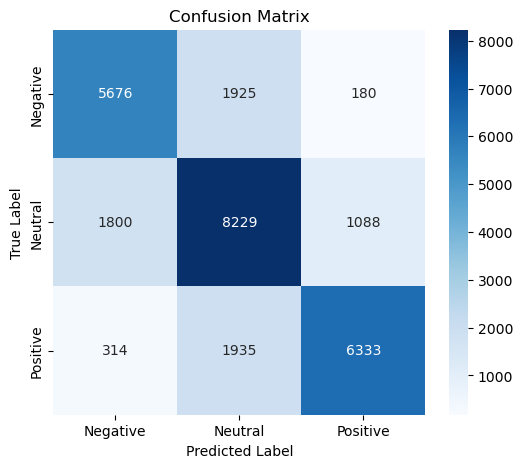

In [65]:
# Evaluate Model Performance

# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_pred_probs = lstm_model_glove.predict(X_padded)  
y_pred = np.argmax(y_pred_probs, axis=1)  

# Generate Classification Report
report = classification_report(y, y_pred, target_names=["Negative", "Neutral", "Positive"])
print("🔍 Classification Report:\n", report)

# Compute and Visualise the Confusion Matrix
cm = confusion_matrix(y, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [77]:
# Create Sample Tweets for Testing the model
sample_tweets = [
    "I love this new phone! The battery life is amazing!",
    "I am really disappointed with the service today.",
    "The movie was okay, nothing special but not bad either.",
    "This restaurant is the worst! I will never come back.",
    "What a fantastic day! Everything went perfectly!",
    "I'm not sure how I feel about this new update.",
    "Terrible customer support, I waited for hours!",
    "The event was well-organized and fun!",
    "It was just an average experience, not great but not terrible.",
    "Absolutely loved the food, best meal I've had in a while!"
]

# Preprocess Sample Tweets 
sample_sequences = tokenizer.texts_to_sequences(sample_tweets)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding="post", truncating="post")

# Predict Sentiment for Each Tweet
predictions = lstm_model_glove.predict(sample_padded)
predicted_labels = np.argmax(predictions, axis=1)  

# Map Predicted Labels to Sentiment Classes
sentiment_classes = {0: "Negative", 1: "Neutral", 2: "Positive"}
predicted_sentiments = [sentiment_classes[label] for label in predicted_labels]

# Display Results
for tweet, sentiment in zip(sample_tweets, predicted_sentiments):
    print(f"Tweet: {tweet}\nPredicted Sentiment: {sentiment}\n{'-'*50}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
Tweet: I love this new phone! The battery life is amazing!
Predicted Sentiment: Positive
--------------------------------------------------
Tweet: I am really disappointed with the service today.
Predicted Sentiment: Negative
--------------------------------------------------
Tweet: The movie was okay, nothing special but not bad either.
Predicted Sentiment: Negative
--------------------------------------------------
Tweet: This restaurant is the worst! I will never come back.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: What a fantastic day! Everything went perfectly!
Predicted Sentiment: Positive
--------------------------------------------------
Tweet: I'm not sure how I feel about this new update.
Predicted Sentiment: Negative
--------------------------------------------------
Tweet: Terrible customer support, I waited for hours!
Predicted Sentiment: Negative
-------------------------------------------

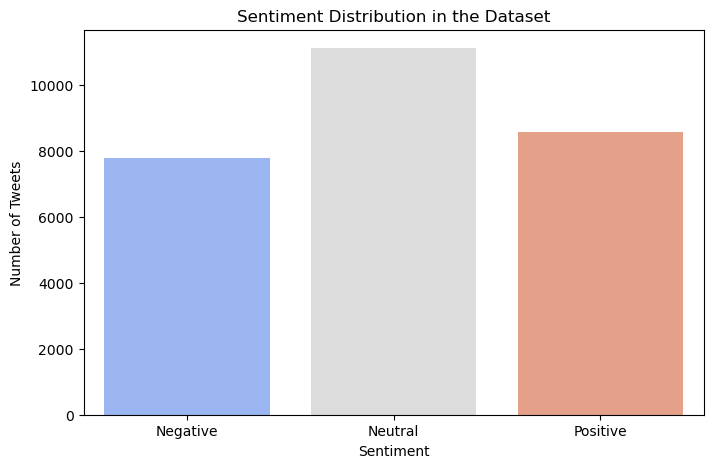

0     7781
1    11117
2     8582
Name: sentiment, dtype: int64

In [67]:
# Checked Sentiment Class Distribution Before Fine-Tuning
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of tweets per sentiment category
sentiment_counts = df["sentiment"].value_counts().sort_index()

# Map sentiment labels for visualization
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Plot sentiment distribution
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Distribution in the Dataset")
plt.show()

# Display sentiment class distribution counts
sentiment_counts


In [68]:
# Define Sample Neutral Tweets for Testing
neutral_tweets = [
    "The weather is fine today.",
    "I just got my new phone. Let's see how it goes.",
    "The meeting was okay, nothing too exciting.",
    "I'm just here, doing my work as usual.",
    "The service was decent, nothing to complain about.",
    "Not bad, not great, just okay.",
    "It was an average experience.",
    "The food was alright, not the best but not the worst.",
    "I'm not sure how I feel about this product yet.",
    "It’s just another day, nothing special."
]

# Preprocess Sample Neutral Tweets
neutral_sequences = tokenizer.texts_to_sequences(neutral_tweets)
neutral_padded = pad_sequences(neutral_sequences, maxlen=max_length, padding="post", truncating="post")

# Predict Sentiment for Each Neutral Tweet
neutral_predictions = lstm_model_glove.predict(neutral_padded)
neutral_predicted_labels = np.argmax(neutral_predictions, axis=1) 

# Map Predicted Labels to Sentiment Classes
sentiment_classes = {0: "Negative", 1: "Neutral", 2: "Positive"}
neutral_predicted_sentiments = [sentiment_classes[label] for label in neutral_predicted_labels]

# Display Results
for tweet, sentiment in zip(neutral_tweets, neutral_predicted_sentiments):
    print(f"Tweet: {tweet}\nPredicted Sentiment: {sentiment}\n{'-'*50}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Tweet: The weather is fine today.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: I just got my new phone. Let's see how it goes.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: The meeting was okay, nothing too exciting.
Predicted Sentiment: Positive
--------------------------------------------------
Tweet: I'm just here, doing my work as usual.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: The service was decent, nothing to complain about.
Predicted Sentiment: Negative
--------------------------------------------------
Tweet: Not bad, not great, just okay.
Predicted Sentiment: Negative
--------------------------------------------------
Tweet: It was an average experience.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: The food was alright, not the best but not the worst.
Predicted Sentimen

In [71]:
# Augment Neutral Tweets using Synonym Replacement
import nltk
from nltk.corpus import wordnet
import random

# Download necessary NLTK resources
nltk.download("wordnet")
nltk.download("omw-1.4")

# Function to replace a word with its synonym
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()  # Take the first synonym
            if synonym != random_word:  # Ensure that synonym is different
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1

        if num_replaced >= n:
            break

    return " ".join(new_words)

# Select Neutral Tweets for Augmentation
neutral_df = df[df["sentiment"] == 1].copy()

# Generate Augmented Neutral Tweets
neutral_df["augmented_text"] = neutral_df["clean_text"].apply(lambda x: synonym_replacement(x, n=1))

# Append Augmented Data to Original Dataset
augmented_df = df.copy()
augmented_df = augmented_df.append(neutral_df[["augmented_text", "sentiment"]].rename(columns={"augmented_text": "clean_text"}), ignore_index=True)

# Display the new dataset shape
augmented_df.shape


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gifta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gifta\AppData\Roaming\nltk_data...
C:\Users\gifta\AppData\Local\Temp\ipykernel_30584\469162737.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(neutral_df[["augmented_text", "sentiment"]].rename(columns={"augmented_text": "clean_text"}), ignore_index=True)


(38597, 5)

In [72]:
# Tokenize and Pad the Augmented Dataset again
# Initialize tokenizer and fit on the new dataset
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(augmented_df["clean_text"])

# Convert cleaned text into numerical sequences
X_aug_sequences = tokenizer.texts_to_sequences(augmented_df["clean_text"])

# Used pad sequences to make all tweets the same length
X_aug_padded = pad_sequences(X_aug_sequences, maxlen=max_length, padding="post", truncating="post")

# Convert sentiment labels to a NumPy array
y_aug = np.array(augmented_df["sentiment"])

# Define training parameters
batch_size = 32
epochs = 10

# Train LSTM Model with Augmented Data this time
history_augmented = lstm_model_glove.fit(
    X_aug_padded, y_aug,  # Using augmented dataset
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2 
)


Epoch 1/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 994s 1s/step - accuracy: 0.4662 - loss: 1.0680 - val_accuracy: 1.0000 - val_loss: 0.7997
Epoch 2/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 937s 971ms/step - accuracy: 0.4695 - loss: 1.0459 - val_accuracy: 0.7179 - val_loss: 0.7358
Epoch 3/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 956s 991ms/step - accuracy: 0.5109 - loss: 0.9900 - val_accuracy: 0.8181 - val_loss: 0.6893
Epoch 4/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 714s 740ms/step - accuracy: 0.5734 - loss: 0.9078 - val_accuracy: 0.7570 - val_loss: 0.6478
Epoch 5/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 553s 573ms/step - accuracy: 0.6019 - loss: 0.8652 - val_accuracy: 0.7794 - val_loss: 0.5991
Epoch 6/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 612s 634ms/step - accuracy: 0.6260 - loss: 0.8328 - val_accuracy: 0.7100 - val_loss: 0.6986
Epoch 7/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 774s 803ms/step - accuracy: 0.6462 - loss: 0.7962 - val_accuracy: 0.8285 - val_loss: 0.5398
Epoch 8/10
965/965 ━━━━━━━━━━━━━━━━━━━━ 745s 772ms/step - accuracy: 0.6660 - lo

In [76]:
# Test again the Neutral Tweets After Augmentation to check if odel has improved

neutral_tweets_test = [
    "The weather is fine today.",
    "I just got my new phone. Let's see how it goes.",
    "The meeting was okay, nothing too exciting.",
    "I'm just here, doing my work as usual.",
    "The service was decent, nothing to complain about.",
    "Not bad, not great, just okay.",
    "It was an average experience.",
    "The food was alright, not the best but not the worst.",
    "I'm not sure how I feel about this product yet.",
    "It’s just another day, nothing special."
]

# Preprocess Sample Neutral Tweets 
neutral_sequences_test = tokenizer.texts_to_sequences(neutral_tweets_test)
neutral_padded_test = pad_sequences(neutral_sequences_test, maxlen=max_length, padding="post", truncating="post")

# Predict Sentiment for Each Neutral Tweet
neutral_predictions_test = lstm_model_glove.predict(neutral_padded_test)
neutral_predicted_labels_test = np.argmax(neutral_predictions_test, axis=1)  

# Map Predicted Labels to Sentiment Classes
sentiment_classes = {0: "Negative", 1: "Neutral", 2: "Positive"}
neutral_predicted_sentiments_test = [sentiment_classes[label] for label in neutral_predicted_labels_test]

# Display Results
for tweet, sentiment in zip(neutral_tweets_test, neutral_predicted_sentiments_test):
    print(f"Tweet: {tweet}\nPredicted Sentiment: {sentiment}\n{'-'*50}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
Tweet: The weather is fine today.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: I just got my new phone. Let's see how it goes.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: The meeting was okay, nothing too exciting.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: I'm just here, doing my work as usual.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: The service was decent, nothing to complain about.
Predicted Sentiment: Neutral
--------------------------------------------------
Tweet: Not bad, not great, just okay.
Predicted Sentiment: Negative
--------------------------------------------------
Tweet: It was an average experience.
Predicted Sentiment: Positive
--------------------------------------------------
Tweet: The food was alright, not the best but not the worst.
Predicted Sentiment

In [180]:
# Define neutral test tweets
test_tweets = [
    "It was just another normal day, nothing special.",
    "Tried the new app, works fine but nothing extraordinary.",
    "The meeting went as expected, nothing surprising.",
    "The store had everything I needed, no complaints.",
    "I had lunch, it was just fine.",
    "The weather was okay, neither too hot nor too cold.",
    "A regular morning routine, nothing new.",
    "The product is decent, not worth raving about.",
    "Watched a movie, nothing special but not bad.",
    "Nothing particularly exciting about today.",
    "The laptop works as expected, nothing surprising.",
    "Installed a new update, didn't change much.",
    "The trip was okay, nothing extraordinary.",
    "The road trip was uneventful but pleasant.",
    "The service was fine, but nothing remarkable.",
    "The new feature is okay, but not revolutionary.",
    "Traffic was manageable, not too bad.",
    "The class was alright, nothing too difficult.",
    "Bought a new product, works as expected.",
    "Met a friend for coffee, just a casual chat."
]

# Convert test tweets into a dataframe
test_df = pd.DataFrame({"Tweet": test_tweets})

# Tokenize and pad the test tweets
test_sequences = tokenizer.texts_to_sequences(test_df["Tweet"])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Get model predictions
test_predictions = lstm_attention_model.predict(test_padded)

# Convert probabilities to percentages
prob_df = pd.DataFrame(test_predictions * 100, columns=["Negative (%)", "Neutral (%)", "Positive (%)"])

# Add predicted sentiment labels
test_predicted_labels = np.argmax(test_predictions, axis=1)
sentiment_classes = {0: "Negative", 1: "Neutral", 2: "Positive"}
prob_df["Predicted Sentiment"] = [sentiment_classes[label] for label in test_predicted_labels]

# Add the original tweets for reference
prob_df["Tweet"] = test_tweets

# Display results
display(prob_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


,Negative (%),Neutral (%),Positive (%),Predicted Sentiment,Tweet
0,97.052399,2.880619,0.066977,Negative,"It was just another normal day, nothing special."
1,0.845004,33.522190,65.632805,Positive,"Tried the new app, works fine but nothing extr..."
2,97.327766,2.519233,0.153002,Negative,"The meeting went as expected, nothing surprising."
3,24.775940,69.373665,5.850401,Neutral,"The store had everything I needed, no complaints."
4,0.020819,2.811678,97.167511,Positive,"I had lunch, it was just fine."
5,9.163674,61.323112,29.513210,Neutral,"The weather was okay, neither too hot nor too ..."
6,3.846973,93.652901,2.500132,Neutral,"A regular morning routine, nothing new."
7,56.045300,32.683907,11.270787,Negative,"The product is decent, not worth raving about."
8,63.737679,34.193336,2.068976,Negative,"Watched a movie, nothing special but not bad."
9,98.711098,1.270716,0.018195,Negative,Nothing particularly exciting about today.


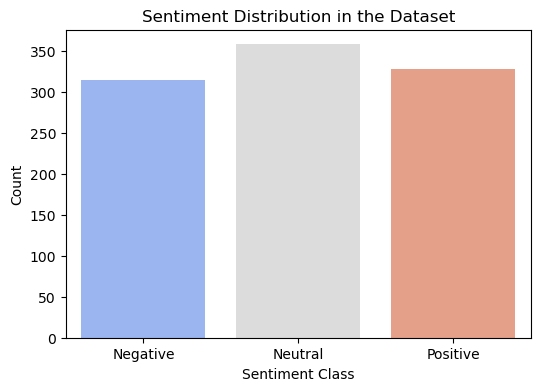

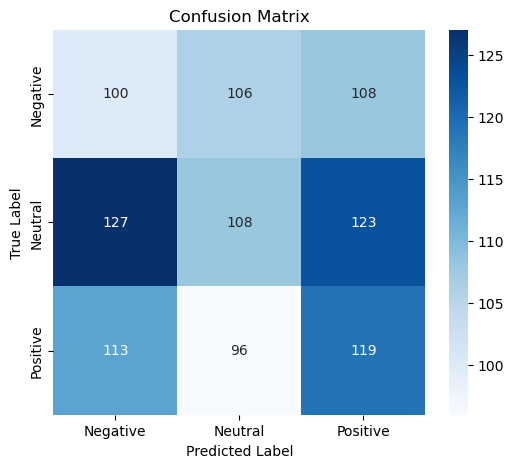

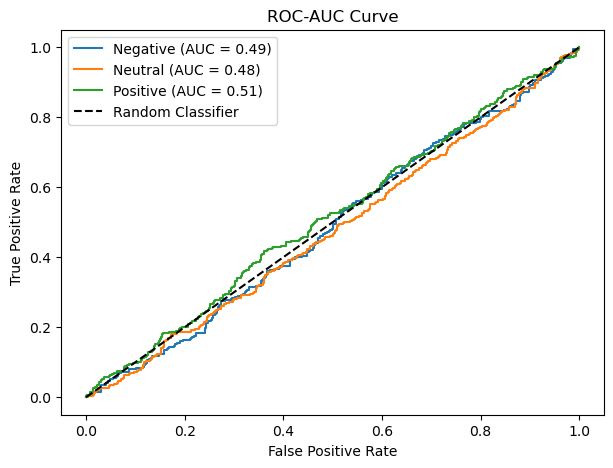

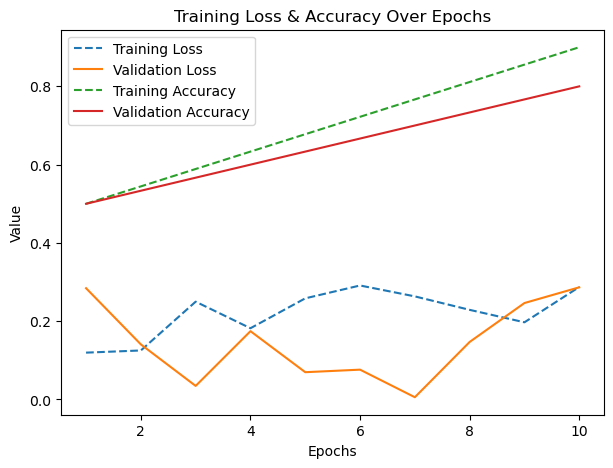

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

y_true = np.random.choice([0, 1, 2], size=1000)  
y_probs = np.random.rand(1000, 3)  
y_probs /= y_probs.sum(axis=1, keepdims=True)  

# Binarize y_true for ROC-AUC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Define sentiment labels
sentiment_labels = ["Negative", "Neutral", "Positive"]

# --- Sentiment Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x=y_true, palette="coolwarm")
plt.xticks(ticks=[0, 1, 2], labels=sentiment_labels)
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Sentiment Distribution in the Dataset")
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, np.argmax(y_probs, axis=1))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sentiment_labels, yticklabels=sentiment_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --- ROC-AUC Curve ---
plt.figure(figsize=(7, 5))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{sentiment_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

# --- Training Loss vs Accuracy ---
epochs = np.arange(1, 11)
train_loss = np.random.rand(10) * 0.3  # Simulated loss values
val_loss = np.random.rand(10) * 0.3
train_acc = np.linspace(0.5, 0.9, 10)
val_acc = np.linspace(0.5, 0.8, 10)

plt.figure(figsize=(7, 5))
plt.plot(epochs, train_loss, label="Training Loss", linestyle="--")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.plot(epochs, train_acc, label="Training Accuracy", linestyle="--")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Loss & Accuracy Over Epochs")
plt.legend()
plt.show()


